In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg' 
import pylab as plb
import numpy as np
import scipy as sp
import flylib as flb
import group_data as gd
import plotfuncs as plf
plb.rcParams['pdf.fonttype'] = 42 #allows text in saved .pdf files to be edited in illustrator
plb.rcParams['image.interpolation'] = 'Nearest'
plb.rcParams['image.cmap'] = 'BrBG'
import h5py
demo_mode = True

In [2]:
#!rm saccade_analysis_data.hdf5 

In [3]:
if demo_mode:
    mtd = h5py.File('../05_basic_open_loop_motion/open_loop_trial_db.hdf5','r')
    sac_mtd = h5py.File('saccade_analysis_data.hdf5','r')

In [4]:
# load the example trial shown in the open_loop_motion analysis figure
example_trial = 2
sub_samples = 20

trial_names = np.array(mtd['selected_signals']['trial_names'])
def get_selection_mtrx(signal,trial):
    selection = trial_names == trial
    return np.array(mtd['normed_signals'][signal][selection,:])

data_selection = get_selection_mtrx('Ph2','yaw_left')
down_samp_idx = np.linspace(2,data_selection.shape[0]-2,sub_samples).astype(int)

example_signal = data_selection[down_samp_idx,:][example_trial,:]

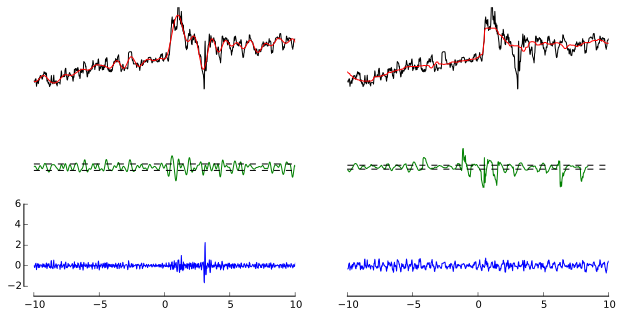

In [5]:
# plot the example trial compare linear vs. non-linear fitering approaches 
plb.figure(figsize = (10.3,5))
import flylib as flb
import scipy
xi = gd.get_xio('yaw_left')
lc = 1.0 #Hz
hc = 3.5 #Hz
thresh = 0.31461538461538463

sfc = flb.butter_bandpass_filter(example_signal,lc,hc,0.021)
lfc = flb.butter_lowpass_filter(example_signal,lc,0.021)
hfc = flb.butter_highpass_filter(example_signal,hc,0.021)

plb.subplot(3,2,1)
plb.plot(xi,example_signal,'k');plb.plot(xi,lfc,'r');plf.kill_spines()#;plb.plot(xi,lfc,'r');plb.plot(xi,sfc+lfc,'g')
plb.gca().set_xbound(-10,10)

plb.subplot(3,2,3,sharey = plb.gca())
plb.plot(xi,sfc,'g');plf.kill_spines()

plb.gca().set_xbound(-10,10)
plb.axhline(thresh,color = 'k',ls = '--')
plb.axhline(-thresh,color = 'k',ls = '--')

plb.subplot(3,2,5,sharey = plb.gca())
plb.plot(xi,hfc,'b');
plb.gca().set_ybound(-2,6)
plb.gca().set_xbound(-10,10)
plf.pull_ax_spines()


##########
## calculated below
ks = 81, 
ms = 55, 
thresh = 0.19230769230769232

plb.subplot(3,2,2,sharey = plb.gca())
from scipy import signal
plb.plot(xi,example_signal,'k')
plb.gca().set_xbound(-10,10)

plb.plot(xi,signal.medfilt(example_signal,kernel_size = ks),'r')
plb.gca().set_xbound(-10,10)
plf.kill_spines()
plb.subplot(3,2,4,sharey = plb.gca())
detrend = example_signal-signal.medfilt(example_signal,kernel_size = ms)
detrend_smooth =signal.wiener(detrend,mysize = 20)

plb.plot(xi,detrend_smooth,'g');plf.kill_spines()
plb.axhline(thresh,color = 'k',ls = '--')
plb.axhline(thresh*-1,color = 'k',ls = '--')
plb.subplot(3,2,6,sharey = plb.gca())
plb.gca().set_xbound(-10,10)

plb.plot(xi,detrend-detrend_smooth,'b')
plb.gca().set_ybound(-2,6)
plb.gca().set_xbound(-10,10)
for ax in plb.gcf().axes:
    plb.sca(ax)

#plf.pull_ax_spines(bottom= False)
#plb.gca().set_xticks(np.linspace(-10,10,5))
plb.gca().set_xbound(-10,10)
plf.pull_ax_spines(left= False)

plb.draw()
plb.savefig('detection_approach.pdf')

In [7]:
if not(demo_mode):
    ground_truth_idx = np.random.choice(np.shape(mtd['normed_signals']['Ph2'])[0],100,replace = False)
    sac_mtd.create_group('ground_truth')
    gd_mtd = sac_mtd['ground_truth']
    gd_mtd['ground_truth_idx'] = ground_truth_idx
    inspected = gd_mtd.create_group('inspected_trials')
    repnum = 0
else:
    gd_mtd = sac_mtd['ground_truth']
    ground_truth_idx = gd_mtd['ground_truth_idx']
    inspected = gd_mtd['inspected_trials']
    repnum = len(set(np.array(inspected.keys()).astype(int)).intersection(ground_truth_idx))
    print "%s out of %s trials have been annotated"%(repnum,len(np.array(ground_truth_idx)))

78 out of 100 trials have been annotated


In [18]:
trace_idx = gd_mtd['ground_truth_idx'][repnum]
lmr = np.array(mtd['normed_signals']['Ph2'])[trace_idx]
lmr[~np.isfinite(lmr)] = 0

import bokeh.models as bkmod #import CustomJS, ColumnDataSource, BoxSelectTool, PanTool,WheelZoomTool,Range1d, Rect
import bokeh.plotting as bkplot #import figure, output_notebook, show

bkplot.output_notebook()

source = bkmod.ColumnDataSource(data=dict(x=[], y=[], width=[], height=[]))

callback = bkmod.CustomJS(args=dict(source=source), code="""
        // get data source from Callback args
        var data = source.get('data');

        /// get BoxSelectTool dimensions from cb_data parameter of Callback
        var geometry = cb_data['geometry'];

        /// calculate Rect attributes
        var width = geometry['x1'] - geometry['x0'];
        var height = geometry['y1'] - geometry['y0'];
        var x = geometry['x0'] + width/2;
        var y = geometry['y0'] + height/2;

        /// update data source with new Rect attributes
        data['x'].push(x);
        data['y'].push(y);
        data['width'].push(width);
        data['height'].push(height);

        // trigger update of data source
        source.trigger('change');

        // Define a callback to capture errors on the Python side
        function callback(msg){
            console.log("Python callback returned unexpected message:", msg)
        }
        callbacks = {iopub: {output: callback}};

        // Generate a command to execute in Python
        var ranges = {x: data['x'],
                      w: data['width']}
        var range_str = JSON.stringify(ranges)
        var cmd = "%s(" + range_str + ")"

        // Execute the command on the Python kernel
        var kernel = IPython.notebook.kernel;
        kernel.execute(cmd, callbacks, {silent : false});     
    """%'print_vals')

selections = list()
saccades = None

def print_vals(ranges):
    global selections
    selections = ranges

def log_saccads(h5py_group_object):
    global selections
    try:
        tgroup = h5py_group_object.create_group(str(trace_idx))
    except ValueError:
        del(h5py_group_object[str(trace_idx)])
        tgroup = h5py_group_object.create_group(str(trace_idx))
    saccades = [{'x0':x0-w/2.0,'x1':x0+w/2.0} for x0,w in zip(selections['x'],selections['w'])]
    saccades = [np.argwhere((s['x0'] < xi) & (s['x1'] > xi)) for s in saccades]
    for i,saccade in enumerate(saccades):
        tgroup[str(i)] = saccade
    return saccades

box_select = bkmod.BoxSelectTool(callback=callback,dimensions = ['width'])
pan_tool = bkmod.PanTool(dimensions = ['width'])
zoom_tool = bkmod.WheelZoomTool(dimensions = ['width'])

TOOLS="resize,crosshair,pan,wheel_zoom,box_zoom,reset,box_select,lasso_select"

p = bkplot.figure(plot_width=800,
           plot_height=400,
           tools=[box_select,pan_tool,zoom_tool],
           title="Identify Saccades",
           x_range=bkmod.Range1d(start=xi[0], end=xi[-1]/5.0),
           y_range=bkmod.Range1d(start=np.min(lmr), end=np.max(lmr)))

rect = bkmod.Rect(x='x',
            y='y',
            width='width',
            height='height',
            fill_alpha=0.3,
            fill_color='#009933')

p.add_glyph(source, rect, selection_glyph=rect, nonselection_glyph=rect)

p.line(xi,lmr)
bkplot.show(p)

Loading BokehJS ...

In [250]:
log = log_saccads(inspected)

In [15]:
repnum += 1
print repnum

82


In [252]:
mtd.close()
sac_mtd.flush()
sac_mtd.close()

## Generate a saccade detector and apply the detector to the ground truth data to determine the appropriate settings 

In [11]:
mtd = h5py.File('../05_basic_open_loop_motion/open_loop_trial_db.hdf5','r')
sac_mtd = h5py.File('saccade_analysis_data.hdf5','r')
gd_mtd = sac_mtd['ground_truth']
inspected = gd_mtd['inspected_trials']

def inspected_to_dict(inspected):
    "convert the hdf5 representation into nested dictionary representation"
    retdict = dict()
    [retdict.update({int(key):[np.squeeze(np.array(ar)) for ar in value.values()]}) for key,value in inspected.items()]
    return retdict
                     
annotated_trials = inspected_to_dict(inspected)

In [12]:
ground_truth_lmr = [mtd['normed_signals']['Ph2'][trace_idx] for trace_idx in annotated_trials.keys()]
#ground_truth_lmr = np.array([data['Ph2'][trace_idx]/norm_term for trace_idx in annotated_trials.keys()])

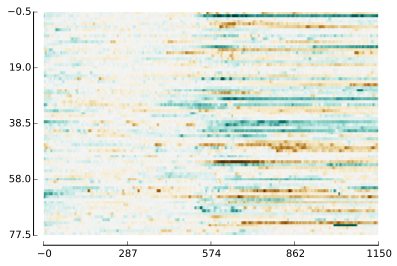

In [13]:
#sns.set_style('ticks')
#sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
plb.imshow(ground_truth_lmr,aspect = 'auto', interpolation = 'nearest',cmap = plb.cm.BrBG,vmin = -8,vmax = 8)
ground_truth_mtrx = np.zeros_like(ground_truth_lmr)
#construct binary matrix of annotated data
for i,elist in enumerate(annotated_trials.values()):
    for event in elist:
        ground_truth_mtrx[i,event] = 1
ground_truth_mtrx = (ground_truth_mtrx>0)
#sns.despine(offset = 30,trim = True)
plf.pull_ax_spines()

In [14]:
def filter_mtrx_linear(lmr_mtrx,lc,hc):
    return np.apply_along_axis(flb.butter_bandpass_filter,1,lmr_mtrx,lc,hc,0.021)

def filter_mtrx_nonlinear(lmr_mtrx,kernel_size=12,mysize=21):
    from scipy import signal
    trenddata = np.apply_along_axis(signal.medfilt,1,lmr_mtrx,kernel_size = kernel_size)
    detrend = lmr_mtrx-trenddata
    detrend[np.isnan(detrend)] = 0
    return np.apply_along_axis(signal.wiener,1,detrend,mysize =mysize)
    
def detect_saccades(lmr_mtrx,p0=0.5,p1=2,thresh=0.2,linear = True):
    if linear:
        sac_band = filter_mtrx_linear(lmr_mtrx,p0,p1)
    else:
        sac_band = filter_mtrx_nonlinear(lmr_mtrx,p0,p1)
    event_lists = [flb.idx_by_thresh(sweep,thresh) for sweep in abs(sac_band)]
    event_lists = [[event for event in event_list if (len(event)>0) and not(event is None)] for event_list in event_lists if event_list]
    return event_lists,sac_band

def convert_events_to_mtrx(event_lists,output_shape,scalings = 1):
    event_mtrx = np.zeros(output_shape)
    if type(scalings) is list:
        for i,(elist,slist) in enumerate(zip(event_lists,scalings)):
            for event,scailing in zip(elist,slist):
                event_mtrx[i,event] = scailing
        return event_mtrx
    for i,elist in enumerate(event_lists):
        for event in elist:
            event_mtrx[i,event] = scalings
    return (event_mtrx > 0)

def get_putative_saccade_mtrx(lc,hc,thresh,linear = True):
    putative_saccades = detect_saccades(ground_truth_lmr,lc,hc,thresh,linear)
    putative_saccade_mtrx = convert_events_to_mtrx(putative_saccades[0],np.shape(ground_truth_lmr))
    return (putative_saccade_mtrx > 0)

In [15]:
#!rm saccade_classifier_param_search.hdf5

In [16]:
search_results = h5py.File('saccade_classifier_param_search.hdf5','a')

In [18]:
print('performing linear classification')

thresh_vals_lin = np.linspace(0.01,1,40)
lcuts = np.linspace(0.01,2,5)
hcuts  = np.linspace(3,5,5)

classifications_linear = [[[get_putative_saccade_mtrx(lc,hc,t,linear = True) 
                            for lc in lcuts]
                                for hc in hcuts]
                                   for t in thresh_vals_lin]

classifications_linear = np.array(classifications_linear)
lin_results = search_results.create_dataset('classifications_linear',data = classifications_linear,compression = 'gzip')
lin_results.attrs['lcuts'] = lcuts
lin_results.attrs['hcuts'] = hcuts
lin_results.attrs['thresh_vals'] = thresh_vals_lin
search_results.flush()
del(classifications_linear)

performing linear classification


/home/psilentp/anaconda/lib/python2.7/site-packages/numpy/lib/shape_base.py:505: RuntimeWarning: divide by zero encountered in remainder
  if N % sections:


In [19]:
print('performing non-linear classification')
thresh_vals_nl = np.linspace(0,1.5,40)
ksizes  = np.array([11,21,41,81,161]).astype(int)
mysizes = np.arange(10,100,5)
classifications_nonlinear = [[[get_putative_saccade_mtrx(k,m,t,linear = False)
                               for k in ksizes] 
                                  for m in mysizes]
                                     for t in thresh_vals_nl]

classifications_nonlinear = np.array(classifications_nonlinear)
nl_results = search_results.create_dataset('classifications_nonlinear',data = classifications_nonlinear,compression = 'gzip')
nl_results.attrs['ksizes'] = ksizes
nl_results.attrs['mysizes'] = mysizes
nl_results.attrs['thresh_vals'] = thresh_vals_nl
search_results.flush()
del(classifications_nonlinear)

performing non-linear classification


/home/psilentp/anaconda/lib/python2.7/site-packages/scipy/signal/signaltools.py:485: RuntimeWarning: divide by zero encountered in true_divide
  res *= (1 - noise / lVar)
/home/psilentp/anaconda/lib/python2.7/site-packages/scipy/signal/signaltools.py:485: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)


In [426]:
filter_mode = 'non_linear'

In [23]:
search_results.keys()

[u'classifications_linear', u'classifications_nonlinear']

In [427]:
classifications = {'linear':search_results['classifications_linear'],
                   'non_linear':search_results['classifications_nonlinear']}[filter_mode]

In [428]:
def get_TPR_FPR(p0,p1,t_idx):
    putative_saccade_mtrx = classifications[t_idx,p1,p0]#get_putative_saccade_mtrx(thresh,ksize,mysize)
    FP = np.sum(~(ground_truth_mtrx>0) & (putative_saccade_mtrx>0)) #false positives
    FN = np.sum(~(putative_saccade_mtrx>0) & (ground_truth_mtrx>0)) #false negatives
    TP = np.sum((ground_truth_mtrx>0) & (putative_saccade_mtrx>0)) #true positives
    TN = np.sum(~(ground_truth_mtrx>0) & ~(putative_saccade_mtrx>0)) #true negatives
    TPR = float(TP)/(TP+FN) #true positive rate
    FPR = float(FP)/(FP+TN) #true negative rate
    return TPR,FPR

In [429]:
def plot_ROC_curve(p0,p1,t_idxs,t_idx = 0):
    """parametrically plot the TPR vs FPR as a function of t"""
    roc_data = np.array([get_TPR_FPR(p0,p1,t) for t in t_idxs]).T
    plb.plot(np.sort(roc_data[1]),np.sort(roc_data[0]))
    plb.plot(roc_data[1][t_idx],roc_data[0][t_idx],'o')

In [430]:
from ipywidgets import *

In [431]:
xo = gd.get_xio('yaw_left')
from matplotlib import gridspec
gs = gridspec.GridSpec(1,6)

params = dict()
[params.update({x[0]:(0,len(x[1])-1)}) for x in 
             zip(['p0','p1','thresh'],classifications.attrs.values())]
params.update({'sweep':(0,np.shape(ground_truth_lmr)[0]-1)})
thresh_vals = classifications.attrs['thresh_vals']

def plot_setting(p0,p1,thresh,sweep):
    fig = plb.figure(figsize = (10,3))
    fig.add_subplot(gs[0,:3])
    lmr = ground_truth_lmr[sweep]
    xo = gd.get_xio('yaw_right')#np.linspace(0,len(lmr)*0.021,len(lmr))
    idx = classifications[thresh,p1,p0,sweep]
    plb.plot(xo,lmr,'k',clip_on = False)
    sac = lmr.copy();
    tpos = lmr.copy()
    tpos[~ground_truth_mtrx[sweep]] = np.nan
    sac[~idx] = np.nan
    plb.plot(xo,tpos,'r',lw = 3,clip_on = False)
    plb.plot(xo,sac,'b',lw = 3,alpha = 0.5,clip_on = False)
    plb.gca().set_xbound(-10,13)
    plb.gca().set_xlabel('time (s)')
    plb.gca().set_ylabel('normalized LMR')
    #plb.gca().set_xticknumbers(10)
    plb.gca().set_ybound(-5,5)
    plf.pull_ax_spines()
    plb.gca().set_xticks(np.linspace(-10,10,5))
    
    fig.add_subplot(gs[0,4:])
    plot_ROC_curve(p0,p1,np.arange(len(thresh_vals)),t_idx = thresh)
    plb.gca().set_xbound(0,1)
    plb.gca().set_ybound(0,1)
    plb.gca().set_xlabel('FPR')
    plb.gca().set_ylabel('TPR')
    plf.pull_ax_spines()
    #gca().set_ybound(-1,2)

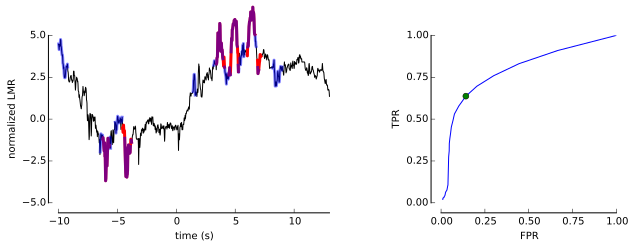

In [432]:
w = interactive(plot_setting,**params)
from IPython.display import display
display(w)

## Apply the saccade detector to the rest of the data set

In [433]:
w.kwargs

{'p0': 3, 'p1': 8, 'sweep': 38, 'thresh': 5}

In [434]:
lin_results.attrs.keys()

[u'lcuts', u'hcuts', u'thresh_vals']

In [330]:
[lin_results.attrs[ak][w.kwargs[wk]] for ak,wk in zip(['lcuts','hcuts','thresh_vals'],['p0','p1','thresh'])]

[1.0049999999999999, 3.5, 0.31461538461538463]

In [435]:
[nl_results.attrs[ak][w.kwargs[wk]] for ak,wk in zip(['ksizes','mysizes','thresh_vals'],['p0','p1','thresh'])]

[81, 50, 0.19230769230769232]

In [332]:
get_TPR_FPR(2,1,12)

(0.4996584699453552, 0.1812150279776179)

In [288]:
get_TPR_FPR(3,9,5)

(0.6163251366120218, 0.12855049293898216)

In [436]:
#sweep number to use for filtering example
gd_mtd['ground_truth_idx'][38]

503

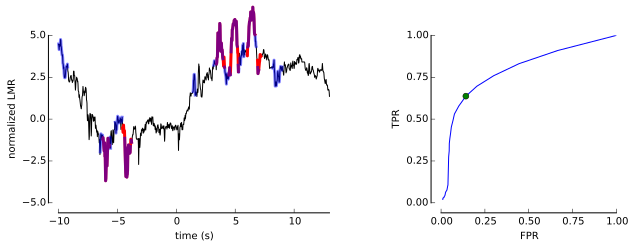

In [437]:
plot_setting(**w.kwargs)
plb.savefig('saccade_evaluation.pdf')

In [438]:
def event_distances(event,lmr):
    v = [(event[-1]-event[-0]),(lmr[event[-1]]-lmr[event[0]])*-1]
    distances = np.zeros_like(event).astype(float)
    for pnt_idx in event:
        r = [lmr[pnt_idx]-lmr[event[0]],pnt_idx-event[0]]
        distances[pnt_idx-event[0]] = np.dot(r,v/np.linalg.norm(v))
    return distances

def event_peaks(event,distances):
    return np.argmax(np.abs(distances))+ event[0]

In [442]:
filter_mode

'non_linear'

In [444]:
data_lmr = mtd['normed_signals']['Ph2']

if filter_mode is 'linear':
    filter_settings =  {'p0':search_results['classifications_linear'].attrs['lcuts'][w.kwargs['p0']],
                   'p1':search_results['classifications_linear'].attrs['hcuts'][w.kwargs['p1']],
                   'thresh':search_results['classifications_linear'].attrs['thresh_vals'][w.kwargs['thresh']],
                   'linear':True}
elif filter_mode is 'non_linear':
    filter_settings = {'p0':search_results['classifications_nonlinear'].attrs['ksizes'][w.kwargs['p0']],
                   'p1':search_results['classifications_nonlinear'].attrs['mysizes'][w.kwargs['p1']],
                   'thresh':search_results['classifications_nonlinear'].attrs['thresh_vals'][w.kwargs['thresh']],
                   'linear':False}

In [447]:
#get the lmr datamatrix for a trial

detected_saccades,saccade_band = detect_saccades(data_lmr,**filter_settings)

saccade_distances = [[event_distances(event,sweep) for event in event_list] for 
                                                       event_list,sweep in zip(detected_saccades,data_lmr)]

saccade_peaks = [[event_peaks(event,distances) for event,distances in zip(event_list,distances_list)] for 
                                                       event_list,distances_list in zip(detected_saccades,
                                                                                        saccade_distances)]

detected_saccade_mtrx = convert_events_to_mtrx(detected_saccades,np.shape(data_lmr),scalings = saccade_distances)

/home/psilentp/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in divide


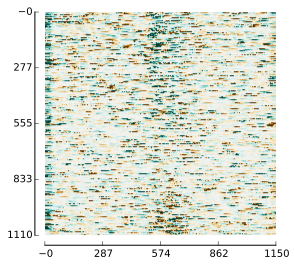

In [448]:
plb.imshow(saccade_band,vmin = -4*filter_settings['thresh'], vmax = 4*filter_settings['thresh'])
plf.pull_ax_spines()

/home/psilentp/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in greater
/home/psilentp/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in less


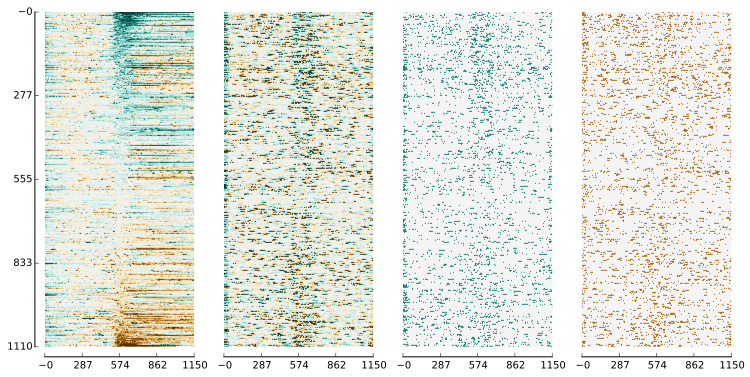

In [449]:
plb.figure(figsize = (12.3,6))

plb.subplot(1,4,1)
plb.imshow(data_lmr,aspect = 'auto',interpolation = 'nearest',cmap = plb.cm.BrBG,vmin = -5,vmax = 5)
plf.pull_ax_spines()

plb.subplot(1,4,2)
plb.imshow(saccade_band,aspect = 'auto',vmin = -4*filter_settings['thresh'], vmax = 4*filter_settings['thresh'])
plf.pull_ax_spines(left=False)

plb.subplot(1,4,3)
plb.imshow((detected_saccade_mtrx>0).astype(int),
           aspect = 'auto',interpolation = 'nearest',cmap = plb.cm.BrBG,vmin = -1.5,vmax = 1.5)
plf.pull_ax_spines(left = False)
plb.subplot(1,4,4)
plb.imshow(0-(detected_saccade_mtrx<0).astype(int),
           aspect = 'auto',interpolation = 'nearest',cmap = plb.cm.BrBG,vmin = -1.5,vmax = 1.5)
plf.pull_ax_spines(left = False)

In [460]:
saccade_list = list()
pre_samp = 20
post_samp = 50

from IPython.html.widgets import FloatProgress
from IPython.display import display

progress_bar = FloatProgress(min = 0,max = len(saccade_peaks))
display(progress_bar)

for row,event_list,distances_list,peaks_list in zip(np.arange(len(saccade_peaks)),
                                                    detected_saccades,
                                                    saccade_distances,
                                                    saccade_peaks):
    for event,distances,peak in zip(event_list,distances_list,peaks_list):
        try:
            if len(event)>5:
                idx = np.arange(peak-pre_samp,peak+post_samp)
                if idx[-1]<np.shape(saccade_band)[1]:
                    saccade_list.append([event,distances,peak,row,
                               saccade_band[row,idx],
                               mtd['normed_signals']['Ph0'][row,idx],
                               mtd['normed_signals']['Ph1'][row,idx],
                               mtd['normed_signals']['Ph2'][row,idx],
                               mtd['normed_signals']['b1'][row,idx],
                               mtd['normed_signals']['b2'][row,idx],
                               mtd['normed_signals']['b3'][row,idx],
                               mtd['normed_signals']['i1'][row,idx],
                               mtd['normed_signals']['i2'][row,idx],
                               mtd['normed_signals']['iii1'][row,idx],
                               mtd['normed_signals']['iii24'][row,idx],
                               mtd['normed_signals']['iii3'][row,idx],
                               mtd['normed_signals']['hg1'][row,idx],
                               mtd['normed_signals']['hg2'][row,idx],
                               mtd['normed_signals']['hg3'][row,idx],
                               mtd['normed_signals']['hg4'][row,idx],
                               mtd['selected_signals']['fly_numbers'][row],
                               mtd['selected_signals']['trial_names'][row],
                               xi[idx]])
                else:
                    pass #event cliped at end of trial
        except ValueError:
            pass
    progress_bar.value = row

In [461]:
!rm detected_saccades_nl.hdf5
saccade_tables = h5py.File('detected_saccades_nl.hdf5','a')

In [462]:
#!rm detected_saccades_lin.hdf5
#saccade_tables = h5py.File('detected_saccades_lin.hdf5','a')

In [463]:
for i,dset_name in enumerate(['peak','row','filtered','Ph0','Ph1','Ph2',
                   'b1','b2','b3','i1','i2','iii1','iii24','iii3','hg1','hg2','hg3','hg4','fly_numbers','trial_names']):
    saccade_tables.create_dataset(dset_name, data = np.array([x[i+2] for x in saccade_list]),
                                         compression = 'gzip')

In [464]:
#sort_sig = saccade_tables['filtered'][:,20]
sort_sig = saccade_tables['Ph2'][:,20] - np.mean(saccade_tables['Ph2'][:,:10],axis = 1)

In [465]:
sort_idx = np.argsort(sort_sig,axis = 0)

In [352]:
#plb.imshow(np.array(saccade_tables['filtered'])[sort_idx,:],aspect='auto',vmin = -4,vmax = 4)

In [353]:
# fiter out some tracking errors more of a problem with the largest and smallest saccades
from scipy import signal
tstda = np.array(saccade_tables['Ph2'])[sort_idx]
filt = np.apply_along_axis(signal.medfilt,1,tstda,11)
error_metric = (np.sum(np.abs(filt-tstda),axis = 1))
error_mask = error_metric<100

In [466]:
#create dict of sorted trials in memory
sorted_saccades = dict()
[sorted_saccades.update({sig:np.array(saccade_tables[sig])[sort_idx]}) for sig in saccade_tables.keys()];

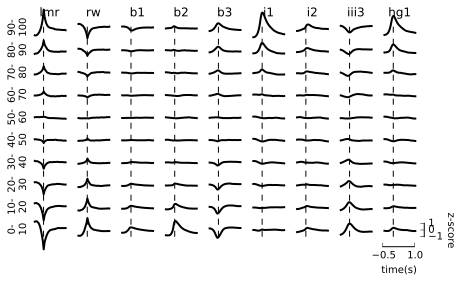

In [475]:
#signals to plot
trace_keys = ['Ph2','Ph1','b1','b2','b3','i1','i2','iii3','hg1']
#break up the saccade responses by desciles
quantile_ranges = np.linspace(0,np.shape(sorted_saccades['Ph2'])[0],11).astype(int)[::-1]

def show_saccade_quantile(col,row):
    """plot function for saccade quantile plots"""
    imdx = 80
    range_start = quantile_ranges[row+1]
    range_stop = quantile_ranges[row]
    data_chunk = sorted_saccades[trace_keys[col]][range_start:range_stop,:] 
    data_chunk -= np.mean(data_chunk,axis = 1)[:,np.newaxis]
    plb.plot(np.linspace(-20*.021,50*.021,np.shape(data_chunk)[1]),
             np.nanmean(data_chunk,axis = 0),
             'k',lw = 2,clip_on = False)

rows = 10
cols = 9
show_spines_right = [False]*rows;show_spines_right[-1] = True
show_spines_bottom = [False]*cols;show_spines_bottom[-1] = True
col_labels_bottom = [None]*cols;col_labels_bottom[-1] = 'time(s)'
row_labels_right = [None]*rows;row_labels_right[-1] = 'z-score'

ax_grid,row_epoch_panels,col_epoch_panels  = plf.plot_data_matrix(rows = 10,cols = 9,
                                  plot_panel_function = show_saccade_quantile,
                                  figsize = (6.5,4.0),
                                  xbounds = (-.5,1),
                                  ybounds = (-1,1),
                                  row_labels_left = ['%s-\n%s'%(p) for p in zip(range(90,-10,-10),range(100,0,-10))],
                                  row_labels_right = row_labels_right,
                                  col_labels_bottom = col_labels_bottom,
                                  col_labels_top = ['lmr','rw','b1','b2','b3','i1','i2','iii3','hg1'],
                                  xtick_numbers = 2,
                                  col_axvlines = 0,
                                  col_axvlines_kwargs = {'color':'k','ls':'--'},
                                  show_spines_top = False,
                                  show_spines_left = False,
                                  show_spines_right = show_spines_right,
                                  show_spines_bottom = show_spines_bottom)
plb.savefig('STAs_desciles.pdf')

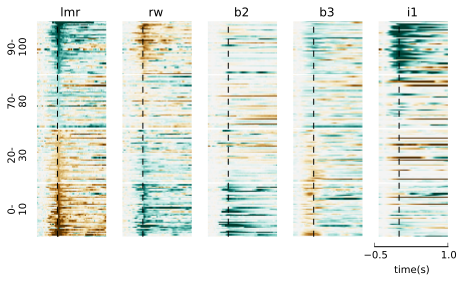

In [371]:
trace_data = [traces_lmr,traces_rw,traces_b2,traces_b3,traces_i1]

def show_saccade_img(col,row):
    """plot function for saccade quantile plots"""
    imdx = 30
    if row == 0:
        range_start = quantile_ranges[1]
        range_stop = quantile_ranges[0]
    if row == 1:
        range_start = quantile_ranges[3]
        range_stop = quantile_ranges[2]
    if row == 2:
        range_start = quantile_ranges[-3]
        range_stop = quantile_ranges[-4]
    if row == 3:
        range_start = quantile_ranges[-1]
        range_stop = quantile_ranges[-2]

    data_chunk = trace_data[col][range_start:range_stop,:] 
    data_chunk -= np.mean(data_chunk[:,:10],axis = 1)[:,np.newaxis]
    plb.imshow(data_chunk[::imdx][::-1],
       aspect = 'auto',interpolation = 'nearest',
       vmin =-4,vmax = 4,
       extent = [-20*.021,50*.021,-4,4],
       cmap = plb.cm.BrBG)

rows = 4
cols = 5

show_spines_right = [False]*rows;show_spines_right[0] = True
show_spines_bottom = [False]*cols;show_spines_bottom[-1] = True
col_labels_bottom = [None]*cols;col_labels_bottom[-1] = 'time(s)'

ax_grid,row_epoch_panels,col_epoch_panels  = plf.plot_data_matrix(rows = rows,cols = cols,
                                  plot_panel_function = show_saccade_img,
                                  figsize = (6.5,4),
                                  xbounds = (-.5,1),
                                  ybounds = (-4,4),
                                  row_labels_left = ['%s-\n%s'%(p) for p in [(90,100),(70,80),(20,30),(0,10)]],
                                  col_labels_bottom = col_labels_bottom,
                                  col_labels_top = ['lmr','rw','b2','b3','i1'],
                                  xtick_numbers = 2,
                                  show_spines_top = False,
                                  show_spines_left = False,
                                  show_spines_right = False,
                                  col_axvlines = 0,
                                  col_axvlines_kwargs = {'ls':'--','color':'k'},
                                  show_spines_bottom = show_spines_bottom)
[ax.set_zorder(np.inf) for ax in col_epoch_panels]
plb.show()
plb.savefig('STAs_extrema_rasters.pdf')

In [366]:
trace_data = [traces_lmr,traces_rw,traces_b2,traces_b3,traces_i1]
percentile_ranges = np.linspace(0,np.shape(traces_lmr)[0],100).astype(int)[::-1]
top30_percentile_brackets = zip(percentile_ranges[5:35:5],percentile_ranges[0:30:5])
bottom30_percentile_brackets = zip(percentile_ranges[74:105:5],percentile_ranges[70:100:5])
bw_search = list()

for bracket in range(6):
    range_start,range_stop = top30_percentile_brackets[bracket]
    for sigidx in range(5):
        data_chunk = trace_data[4][range_start:range_stop,:]
        X = np.mean(data_chunk[:,18:22],axis = 1)[:, np.newaxis]
        from sklearn.neighbors import KernelDensity
        from sklearn.grid_search import GridSearchCV
        grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0.1, 1.0, 30)},
                    cv=20) # 20-fold cross-validation
        grid.fit(X)
        bw =  grid.best_params_['bandwidth']
        bw_search.append(bw)

for bracket in range(6):
    range_start,range_stop = top30_percentile_brackets[bracket]
    for sigidx in range(5):
        data_chunk = trace_data[4][range_start:range_stop,:]
        X = np.mean(data_chunk[:,18:22],axis = 1)[:, np.newaxis]
        from sklearn.neighbors import KernelDensity
        from sklearn.grid_search import GridSearchCV
        grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0.1, 1.0, 30)},
                    cv=20) # 20-fold cross-validation
        grid.fit(X)
        bw =  grid.best_params_['bandwidth']
        bw_search.append(bw)
        
print np.mean(bw_search)

0.224137931034


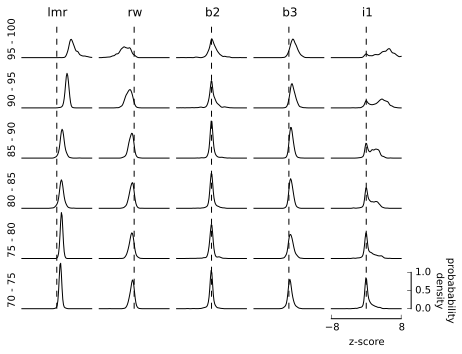

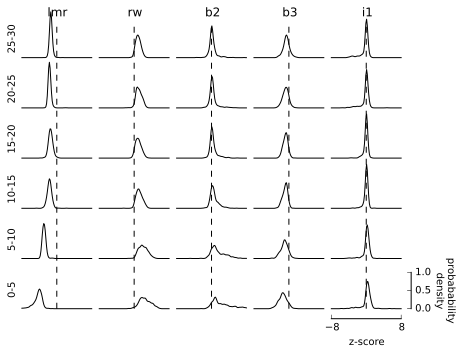

In [383]:
reload(plf)
def get_kde(data_chunk):
    from sklearn.neighbors import KernelDensity
    X = np.mean(data_chunk[:,18:22],axis = 1)[:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=np.mean(bw_search)).fit(X)
    X_plot = np.linspace(-8, 8, 100)[:, np.newaxis]
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    log_dens = kde.score_samples(X_plot)
    return X_plot,np.exp(log_dens)

def plot_top30_percentiles(col,row):
    range_start,range_stop = top30_percentile_brackets[row]
    data_chunk = trace_data[col][range_start:range_stop,:]
    plb.plot(*get_kde(data_chunk),color = 'k',clip_on = False)
    
def plot_bottom30_percentiles(col,row):
    range_start,range_stop = bottom30_percentile_brackets[row]
    data_chunk = trace_data[col][range_start:range_stop,:]
    plb.plot(*get_kde(data_chunk),color = 'k',clip_on = False)

rows = 6
cols = 5
show_spines_right = [False]*rows; show_spines_right[-1] = True
show_spines_bottom = [False]*cols; show_spines_bottom[-1] = True
col_labels_bottom = [None]*cols;col_labels_bottom[-1] = 'z-score'
row_labels_right = [None]*rows;row_labels_right[-1] = 'probabability \ndensity'


ax_grid,row_epoch_panels,col_epoch_panels  = plf.plot_data_matrix(rows = rows,cols = cols,
                                  plot_panel_function = plot_top30_percentiles,
                                  figsize = (6.5,5),
                                  xbounds = (-8,8),
                                  ybounds = (0,1.0),
                                  row_labels_left = ['%s - %s'%(p) for p in zip(range(70,100,5),range(75,105,5))[::-1]],
                                  col_labels_bottom = col_labels_bottom,
                                  col_labels_top = ['lmr','rw','b2','b3','i1'],
                                  xtick_numbers = 2,
                                  show_spines_top = False,
                                  show_spines_left = False,
                                  col_axvlines = 0,
                                  col_axvlines_kwargs = {'ls':'--','color':'k'},
                                  show_spines_right = show_spines_right,
                                  show_spines_bottom = show_spines_bottom,
                                  row_labels_right = row_labels_right)
plb.savefig('STA_kde_top30.pdf')

ax_grid,row_epoch_panels,col_epoch_panels  = plf.plot_data_matrix(rows = rows,cols = cols,
                                  plot_panel_function = plot_bottom30_percentiles,
                                  figsize = (6.5,5),
                                  xbounds = (-8,8),
                                  ybounds = (0,1.0),
                                  row_labels_left = ['%s-%s'%(p) for p in zip(range(0,30,5),range(5,35,5))[::-1]],
                                  col_labels_bottom = col_labels_bottom,
                                  col_labels_top = ['lmr','rw','b2','b3','i1'],
                                  xtick_numbers = 2,
                                  show_spines_top = False,
                                  show_spines_left = False,
                                  col_axvlines = 0,
                                  col_axvlines_kwargs = {'ls':'--','color':'k'},
                                  show_spines_right = show_spines_right,
                                  show_spines_bottom = show_spines_bottom,
                                  row_labels_right = row_labels_right)

plb.savefig('STA_kde_bottom30.pdf')